# Convolution Neural Network avec Keras

In [7]:
import os
import cv2 
# si nécessaire : conda install -c conda-forge opencv   
# ou sinon : https://pypi.org/project/opencv-python/
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

On importe les librairies nécessaires de Keras

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,Softmax
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta
from tensorflow.keras.utils import to_categorical

## Importation et préparation des données

Télécharger les données depuis :

https://box.ec-nantes.fr:443/index.php/s/2NxopNZS3FTRBcr

Adresse du dossier où sont entreposées les données:

In [9]:
#data_path = "data_animals"
data_path = "C://Users//abdou//MathApp//TP6//data_animals"

La fonction `os.listdir()` permet de lister le contenu du dossier `data_animals` (un repertoire par classe).

In [10]:
data_dir_list = os.listdir(data_path)
print(data_dir_list)
num_classes = len(data_dir_list) 
print(num_classes)

['cats', 'dogs', 'horses', 'Humans']
4


Toutes les images ne sont pas au même format (nb de pixels).
Le réseau CNN impose que toutes les données aient la même dimension. Il nous faudra  transformer les images pour qu'elles soient toutes au même format : 128x 128.

In [11]:
img_rows=128
img_cols=128

Lorsque les images en entrée du réseau sont en couleur, on utilise 3 canaux(RGB).

Ici, pour simplifier, nous allons préalablement transformer les images en niveaux de gris et de ce fait nous n'utiliserons qu'un seul canal en entrée du réseau. 

In [12]:
num_channel=1

> Compléter le script ci-dessous pour importer les images en niveaux de gris et sous la forme de tableaux 128x128, dans la liste img_data_list.
*  `my_img = cv2.imread("file")`  : lecture d'un fichier image
*  `cv2.cvtColor(my_img, cv2.COLOR_BGR2GRAY)` : convertit le fichier image en niveaux de gris
*  `cv2.resize(input_img,(n,p))` : redimensionne l'image au format n x p 

In [13]:
from sklearn import preprocessing

img_data_list=[]

for dataset in data_dir_list: # boucle sur les 4 repertoires
    img_list=os.listdir(data_path+'/'+ dataset)  # 

    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img_raw=  cv2.imread(data_path+'/'+ dataset+'/'+img) 
        input_img_grey= cv2.cvtColor(input_img_raw, cv2.COLOR_BGR2GRAY)
        input_img_flatten=cv2.resize(input_img_grey,(128,128)).flatten()
        img_data_list.append(input_img_flatten)

        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')

img_data_scaled = preprocessing.scale(img_data)
print (img_data_scaled.shape)

print (np.mean(img_data_scaled))
print (np.std(img_data_scaled))

print (img_data_scaled.mean(axis=0))
print (img_data_scaled.std(axis=0))  

Loaded the images of dataset-cats

Loaded the images of dataset-dogs

Loaded the images of dataset-horses

Loaded the images of dataset-Humans



c:\Users\abdou\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\abdou\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


(808, 16384)
1.2761886e-08
1.0000001
[ 5.8866963e-08 -5.7686673e-08  2.0360002e-07 ... -3.1646525e-08
 -9.3537984e-08  1.7261740e-08]
[0.99999934 0.99999934 1.0000005  ... 0.99999946 0.9999998  1.0000005 ]


> Quelle la dimension du tableau `img_data` ?

In [14]:
img_data.shape


(808, 16384)

De façon générale, la première couche du réseau de convolution  prend en entrée un objet de dimension 3 : hauteur, largeur, profondeur,  où la profondeur correspond aux nombres de canaux.

Avec Tensor Flow (ici en backend) la profondeur doit être donnée en dernière position.

Cette dimension est ici "factice"  car nos images sont en niveaux gris, elle est néanmoins nécessaire car attendue par les fonctions de Keras et Tensor Flow.

L'échantillon d'images doit finalement se présenter sous la forme d'un objet de dimension 4: (nombre d'échantillons, hauteur, largeur, profondeur)

Nous redimensionnons les données pour qu'elle se présente ainsi :

In [15]:
img_data_reshape=img_data_scaled.reshape(img_data.shape[0],
                                        img_rows,img_cols,
                                        num_channel)
print (img_data_reshape.shape)

(808, 128, 128, 1)


La dimension d'une image en entrée du réseau est la suivante :

In [16]:
input_shape=img_data_reshape[0].shape # (128, 128, 1)
input_shape

(128, 128, 1)

Nous indiquons maintenant les labels des images:

In [17]:
num_of_samples = img_data_reshape.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')
labels[0:202]=0
labels[202:404]=1
labels[404:606]=2
labels[606:]=3

names = ['cats','dogs','horses','humans']

> Convertir les labels en "one-hot encoding"

In [18]:
labels_categorical=to_categorical(labels)

> Séparer  aléatoirement les données en un échantillon d'apprentissage (80%) et un échantillon de test (20%). Assurez-vous que les données d'apprentissage prennent bien la forme d'un tableau de dimension 4.

In [19]:
X_train,X_test,Y_train,Y_test=train_test_split(img_data_reshape,labels_categorical,test_size=0.2)

## Définition de l'architecture du modèle

Nous définissons ci-dessous les deux premiers niveaux de convolution du réseau CNN.
Chacune de ces deux couches est définie comme suit :
+ 32 noyaux (filtres)
+ Pas (stride) = 1
+ Kernel size = (3,3)
+ padding = 'same' (i.e. 0 padding : bordures à 0)
+ activation : relu

> Créer un modèle séquentiel que vous nommerez `my_first_CNN` composé de 4 couches succesives (conv + relu + conv + relu).    
> Voir  [ici](https://keras.io/layers/convolutional/#conv2d) et  [ici](https://keras.io/examples/vision/mnist_convnet/) pour la synthaxe de la couche de convolution `Conv2D`.

In [22]:
from tensorflow import keras
my_first_CNN=Sequential()
my_first_CNN.add(keras.Input(shape=input_shape))
my_first_CNN.add(Conv2D(32,(3,3),1,"same"))
my_first_CNN.add(Activation("relu"))
my_first_CNN.add(Conv2D(32,(3,3),1,"same"))
my_first_CNN.add(Activation("relu"))

> Executez les codes ci-dessous et decrire les sorties obtenues

In [23]:
print(my_first_CNN.layers[0].input_shape)
print(my_first_CNN.layers[1].input_shape)

(None, 128, 128, 1)
(None, 128, 128, 32)


(`batch_size`,`n_l`,`n_c`,`nb de canaux`)

Keras dimensionnera ensuite correctement les couches en fonction du `batch_size` choisi par l'utilisateur. 

> Passer `batch_size=16` en argument de `Conv2D` et vérifier que cela a bien été pris en compte dans les dimensions de la couche cachée de `my_first_CNN`.

In [25]:
my_first_CNN=Sequential()
my_first_CNN.add(keras.Input(shape=input_shape,batch_size=16))
my_first_CNN.add(Conv2D(32,(3,3),1,"same",batch_size=16))
my_first_CNN.add(Activation("relu"))
my_first_CNN.add(Conv2D(32,(3,3),1,"same"))
my_first_CNN.add(Activation("relu"))

print(my_first_CNN.layers[0].input_shape)
print(my_first_CNN.layers[1].input_shape)

(16, 128, 128, 1)
(16, 128, 128, 32)


> Executez les codes ci-dessous et decrire les sorties obtenues. Expliquer en particulier la dimension de la troisième couche en utilisant `get_weights`.

In [26]:
my_first_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (16, 128, 128, 32)        320       
                                                                 
 activation_4 (Activation)   (16, 128, 128, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (16, 128, 128, 32)        9248      
                                                                 
 activation_5 (Activation)   (16, 128, 128, 32)        0         
                                                                 
Total params: 9568 (37.38 KB)
Trainable params: 9568 (37.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
np.shape(my_first_CNN.layers[2].get_weights()[0])

(3, 3, 32, 32)

Multichannel convolution:
\begin{eqnarray} Z(i,j,l) &= & ( V \star K ) (i,j,l) \\
& =  & \sum_{u,v,w}   V (i+u, j+v,w ) w_{u,v,l,w} 
\end{eqnarray}
where 
+ $V$  and $Z$ have the same dimensions (multichannel).
+ $K(u,v,l,w) $ gives the connection strength between a unit in channel $l$ of the output and a unit in channel $w$ of the input, with an offset of  $u$ rows and $v$ columns between the output unit and the input unit.

Le nombre de poids à estimer vaut donc :

In [28]:
l = np.shape(my_first_CNN.layers[2].get_weights()[0]) 
n =  l[0]*l[1]*l[2]*l[3]
print(n)

9216


Le nombre de paramètres à estimer pour les termes de biais :

In [30]:
m=32

On a bien que pour la troisième couche 9248 = 

In [31]:
n+m

9248

> Vérifier que les poids sont (déjà) initialisés aléatoirement alors que les biais sont initialisés à 0. 

In [32]:
print(my_first_CNN.layers[2].get_weights()[0])

[[[[ 0.06154342 -0.06375446  0.06824319 ...  0.09953122  0.04818945
    -0.0644113 ]
   [ 0.05740355 -0.08390391  0.10136208 ... -0.06048429 -0.07210983
     0.03084871]
   [-0.00278319  0.09144276 -0.01403646 ...  0.07744224  0.08234511
     0.07763551]
   ...
   [-0.0874218   0.06035009  0.0644931  ... -0.01828034  0.03839067
    -0.05745257]
   [ 0.06972401 -0.0810774   0.03249556 ... -0.05217262  0.09675905
    -0.02009705]
   [-0.08732924  0.05655104 -0.04011146 ... -0.01282764 -0.00172614
    -0.0258733 ]]

  [[ 0.0947839   0.07115597  0.04316573 ... -0.00986157  0.014954
     0.00964947]
   [ 0.03670846  0.07383087  0.07351643 ... -0.01133153 -0.08561738
     0.08306755]
   [ 0.09376143  0.06201079  0.05803096 ... -0.01011889 -0.00677739
     0.0034454 ]
   ...
   [-0.0545895   0.05521163  0.01328504 ... -0.08796439  0.07224829
    -0.05229154]
   [-0.09714968 -0.01157576  0.06575815 ...  0.01806918  0.06293894
    -0.01088186]
   [ 0.01364401  0.0970442  -0.01682983 ...  0.0989

In [34]:
print(my_first_CNN.layers[2].get_weights()[1])
print(len(my_first_CNN.layers[2].get_weights()[1]))



[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
32


> Construire maintenant l'architecture complète du réseau `my_first_CNN` :
+ Convolution à 32 filtres de taille (3,3), zero padding
+ Activation Relu
+ Convolution à 32 filtres de taille (3,3), zero padding
+ Activation Relu
+ Maxpooling2D (2,2) [documentation](https://keras.io/api/layers/pooling_layers/max_pooling2d/)
+ Dropout(0.5) [documentation](https://keras.io/api/layers/regularization_layers/dropout/)
+ Convolution à 64 filtres de taille (3,3), zero padding
+ Maxpooling2D (2,2) 
+ Dropout(0.5) 
+ Flatten  [documentation](https://keras.io/api/layers/reshaping_layers/flatten/)
+ Dense(64)
+ Activation Relu
+ Dropout(0.5)
+ Dense(4)
+ Softmax   
> 
> Afficher un résumé de l'architecture avec `my_first_CNN.summary` 

In [37]:
my_first_CNN=Sequential()
my_first_CNN.add(keras.Input(shape=input_shape))
my_first_CNN.add(Conv2D(32,(3,3)))
my_first_CNN.add(Activation("relu"))
my_first_CNN.add(Conv2D(32,(3,3)))
my_first_CNN.add(Activation("relu"))
my_first_CNN.add(MaxPooling2D(2,2))
my_first_CNN.add(Dropout(0.5))
my_first_CNN.add(Conv2D(64,(3,3)))
my_first_CNN.add(MaxPooling2D(2,2))
my_first_CNN.add(Dropout(0.5))
my_first_CNN.add(Flatten())
my_first_CNN.add(Dense(64))
my_first_CNN.add(Activation("relu"))
my_first_CNN.add(Dropout(0.5))
my_first_CNN.add(Dense(4))
my_first_CNN.add(Softmax())

In [38]:
my_first_CNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 activation_9 (Activation)   (None, 126, 126, 32)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 124, 124, 32)      9248      
                                                                 
 activation_10 (Activation)  (None, 124, 124, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 62, 62, 32)        0         
                                                      

## Apprentissage du CNN

> Ajuster le modèle 
- avec la méthode sgd (avec un taux d'apprentissage de 0.01 et momentum de 0.9)
- puis la méthode adam.

In [39]:
sgd=SGD(learning_rate=0.01, momentum=0.9)
my_first_CNN.compile(loss='categorical_crossentropy', optimizer=sgd,metrics='categorical_accuracy')
History1=my_first_CNN.fit(X_test,Y_test,batch_size=32,epochs=100)

Epoch 1/100
6/6 [==============================] - 8s 1s/step - loss: 1.4751 - categorical_accuracy: 0.2716
Epoch 2/100
6/6 [==============================] - 6s 1s/step - loss: 1.4448 - categorical_accuracy: 0.2593
Epoch 3/100
6/6 [==============================] - 7s 1s/step - loss: 1.3315 - categorical_accuracy: 0.3457
Epoch 4/100
6/6 [==============================] - 7s 1s/step - loss: 1.3677 - categorical_accuracy: 0.3827
Epoch 5/100
6/6 [==============================] - 7s 1s/step - loss: 1.3412 - categorical_accuracy: 0.4074
Epoch 6/100
6/6 [==============================] - 6s 965ms/step - loss: 1.3085 - categorical_accuracy: 0.4753
Epoch 7/100
6/6 [==============================] - 6s 967ms/step - loss: 1.2183 - categorical_accuracy: 0.4691
Epoch 8/100
6/6 [==============================] - 6s 944ms/step - loss: 1.3025 - categorical_accuracy: 0.3704
Epoch 9/100
6/6 [==============================] - 6s 966ms/step - loss: 1.4108 - categorical_accuracy: 0.4012
Epoch 10/100
6/6

In [40]:
my_first_CNNbis=Sequential()
my_first_CNNbis.add(keras.Input(shape=input_shape))
my_first_CNNbis.add(Conv2D(32,(3,3)))
my_first_CNNbis.add(Activation("relu"))
my_first_CNNbis.add(Conv2D(32,(3,3)))
my_first_CNNbis.add(Activation("relu"))
my_first_CNNbis.add(MaxPooling2D(2,2))
my_first_CNNbis.add(Dropout(0.5))
my_first_CNNbis.add(Conv2D(64,(3,3)))
my_first_CNNbis.add(MaxPooling2D(2,2))
my_first_CNNbis.add(Dropout(0.5))
my_first_CNNbis.add(Flatten())
my_first_CNNbis.add(Dense(64))
my_first_CNNbis.add(Activation("relu"))
my_first_CNNbis.add(Dropout(0.5))
my_first_CNNbis.add(Dense(4))
my_first_CNNbis.add(Softmax())

In [41]:
adam=Adam()
my_first_CNNbis.compile(loss='categorical_crossentropy', optimizer=adam,metrics='categorical_accuracy')
History2=my_first_CNNbis.fit(X_test,Y_test,batch_size=32,epochs=100)

Epoch 1/100
6/6 [==============================] - 8s 1s/step - loss: 3.1672 - categorical_accuracy: 0.2593
Epoch 2/100
6/6 [==============================] - 6s 1s/step - loss: 1.9107 - categorical_accuracy: 0.2407
Epoch 3/100
6/6 [==============================] - 7s 1s/step - loss: 1.4615 - categorical_accuracy: 0.2840
Epoch 4/100
6/6 [==============================] - 6s 995ms/step - loss: 1.3919 - categorical_accuracy: 0.3210
Epoch 5/100
6/6 [==============================] - 6s 993ms/step - loss: 1.3480 - categorical_accuracy: 0.4074
Epoch 6/100
6/6 [==============================] - 6s 1s/step - loss: 1.3369 - categorical_accuracy: 0.3889
Epoch 7/100
6/6 [==============================] - 6s 967ms/step - loss: 1.3049 - categorical_accuracy: 0.3519
Epoch 8/100
6/6 [==============================] - 6s 980ms/step - loss: 1.3014 - categorical_accuracy: 0.3086
Epoch 9/100
6/6 [==============================] - 6s 986ms/step - loss: 1.1736 - categorical_accuracy: 0.5062
Epoch 10/100


> Tracer en fonction du nombre d'epochs le risque de cross-entropy ainsi que la précision pour les échantillons d'apprentissage et de validation.

Text(0.5, 1.0, 'Avec la méthode SGD')

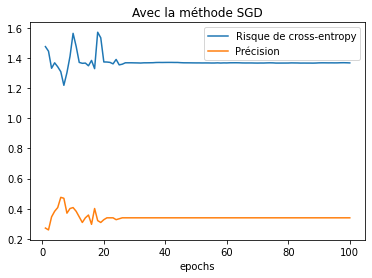

In [42]:
loss = History1.history['loss']
precision = History1.history['categorical_accuracy']
x = np.arange(1, 101)
plt.plot(x, loss, label="Risque de cross-entropy")
plt.plot(x, precision, label="Précision")
plt.xlabel("epochs")
plt.legend()
plt.title("Avec la méthode SGD")

Text(0.5, 1.0, 'Avec la méthode Adam')

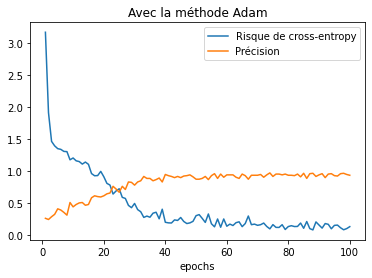

In [43]:
loss=History2.history['loss']
precision=History2.history['categorical_accuracy']
x=np.arange(1,101)
plt.plot(x,loss,label="Risque de cross-entropy")
plt.plot(x,precision,label="Précision")
plt.xlabel("epochs")
plt.legend()
plt.title("Avec la méthode Adam")

> Donner le risque de cross-entropy ainsi que la précision pour l'échantillon de test.

In [44]:
print("Ajusté avec SGD : ", my_first_CNN.evaluate(X_test,Y_test))
print("Ajusté avec Adam : ", my_first_CNNbis.evaluate(X_test,Y_test))

6/6 [==============================] - 2s 336ms/step - loss: 1.3661 - categorical_accuracy: 0.3395
Ajusté avec SGD :  [1.3661166429519653, 0.3395061790943146]
6/6 [==============================] - 2s 214ms/step - loss: 0.0675 - categorical_accuracy: 0.9753
Ajusté avec Adam :  [0.06752222776412964, 0.9753086566925049]


## Matrice de confusion

> Utilisez les outils `classification_report()` et `confusion_matrix()` de `sklearn.metrics` pour décrire les performances du réseau de neurones.

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
Y_pred=my_first_CNNbis.predict(X_test)
Y1=[np.argmax(l) for l in Y_pred]
Y2=to_categorical(Y1)
Y3=[np.argmax(l) for l in Y_test]
print(classification_report(Y_test,Y2))

6/6 [==============================] - 2s 258ms/step
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        38
           1       1.00      1.00      1.00        35
           2       0.93      1.00      0.96        55
           3       1.00      1.00      1.00        34

   micro avg       0.98      0.98      0.98       162
   macro avg       0.98      0.97      0.98       162
weighted avg       0.98      0.98      0.98       162
 samples avg       0.98      0.98      0.98       162



> Afficher la matrice de confusion à l'aide de la fonction `ConfusionMatrixDisplay`

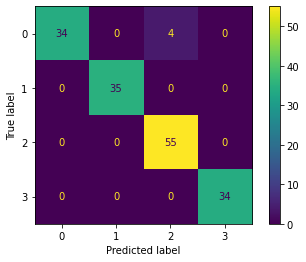

In [46]:
m=confusion_matrix(Y3,Y1)
ConfusionMatrixDisplay(m).plot();

## Sauvegarde d'un réseau de neurones avec Keras

Lorsqu'un modèle a été ajusté, on peut vouloir conserver 
- l'architecture du réseau
- la valeurs des poids des couches
- l'optimiseur utilisé pour ajuster les poids 
- les métriques et les pertes considérées 

Pour répondre aux questions ci-dessous, vous pourrez consulter cette [page](https://keras.io/guides/serialization_and_saving/) de la documentation qui présente en détail les méthodes pour sauvegarder des réseaux Keras.

##### Sauvegarde du modèle (architecture seule) en json

Dans certaines situations, on ne souhaite sauvegarder que l'architecture. Par exemple si on veut comparer plusieurs méthodes d'optimisation des poids d'un même réseau. Il est possible de sauvegarder l'architecture d'un réseau au format JSON.

JavaScript Object Notation (JSON) est un format de données textuelles dérivé de la notation des objets du langage JavaScript. Il permet de représenter de l’information structurée.

Un document JSON a pour fonction de représenter de l'information accompagnée d'étiquettes permettant d'en interpréter les divers éléments, sans aucune restriction sur le nombre de celles-ci.

Un document JSON ne comprend que deux types d'éléments structurels :
+ Des ensembles de paires "nom" (alias "clé") / "valeur" ;
+ Des listes ordonnées de valeurs.

> Sauver l'architecture du réseau au format json.   
> Afficher le contenu du fichier sauvé.   
> Quelle est la taille du fichier json sur votre disque ?

In [47]:
my_json=my_first_CNNbis.to_json()
from json import dump, loads
f= open('data.json', 'w')
dump(my_json, f)
f=open('data.json','r')
print(f.read())

"{\"class_name\": \"Sequential\", \"config\": {\"name\": \"sequential_5\", \"layers\": [{\"module\": \"keras.layers\", \"class_name\": \"InputLayer\", \"config\": {\"batch_input_shape\": [null, 128, 128, 1], \"dtype\": \"float32\", \"sparse\": false, \"ragged\": false, \"name\": \"input_6\"}, \"registered_name\": null}, {\"module\": \"keras.layers\", \"class_name\": \"Conv2D\", \"config\": {\"name\": \"conv2d_12\", \"trainable\": true, \"dtype\": \"float32\", \"filters\": 32, \"kernel_size\": [3, 3], \"strides\": [1, 1], \"padding\": \"valid\", \"data_format\": \"channels_last\", \"dilation_rate\": [1, 1], \"groups\": 1, \"activation\": \"linear\", \"use_bias\": true, \"kernel_initializer\": {\"module\": \"keras.initializers\", \"class_name\": \"GlorotUniform\", \"config\": {\"seed\": null}, \"registered_name\": null}, \"bias_initializer\": {\"module\": \"keras.initializers\", \"class_name\": \"Zeros\", \"config\": {}, \"registered_name\": null}, \"kernel_regularizer\": null, \"bias_re

La taille du fichier json est de 5Kb.

##### Sauvegarde et chargement du modèle complet entrainé

> Utiliser les fonctions `model.save()` et `load_model()` pour sauver et charger un modèle complet (architecture, poids, optimiseur, métriques). Quelle est la taille du répertoire créé pour cette sauvegarde ?

In [49]:
from tensorflow.keras.models import  load_model
my_first_CNNbis.save("model")
model=load_model("model")

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


> Comparer les poids du réseau reconstruit aux poids du réseau originel.

In [50]:

max_norm = 0
layer_indices = [0, 2, 6, 10, 13]

for i in layer_indices:
    weights_my_first_CNNbis = my_first_CNNbis.layers[i].get_weights()[0]
    weights_model = model.layers[i].get_weights()[0]

    weight_diff = weights_my_first_CNNbis - weights_model
    norm = np.linalg.norm(weight_diff)

    if norm > max_norm:
        max_norm = norm

print(max_norm)

0


Les poids des réseaux reconstruit et original sont identiques.

> Vérifier que le modèle chargé peut être directement utilisé pour faire des prédictions ou pour calculer un score.

In [51]:
model.predict(X_test)

6/6 [==============================] - 2s 277ms/step


array([[1.12240626e-08, 9.71247017e-01, 2.85153408e-02, 2.37600965e-04],
       [2.36808688e-08, 5.09738925e-07, 9.99999285e-01, 1.81386767e-07],
       [2.77319820e-08, 9.99154568e-01, 8.44829425e-04, 5.64609991e-07],
       [9.94319439e-01, 2.93978694e-04, 4.69984300e-03, 6.86803076e-04],
       [3.56199402e-12, 4.56828542e-12, 1.00000000e+00, 9.13361817e-11],
       [2.58591747e-16, 1.76720286e-28, 1.00000000e+00, 2.04011948e-16],
       [9.99999881e-01, 7.38744745e-08, 1.68621010e-08, 9.85461757e-09],
       [4.83643204e-12, 4.99681776e-18, 1.00000000e+00, 3.37389323e-13],
       [1.45181345e-09, 2.75734067e-08, 1.00000000e+00, 3.12666271e-09],
       [3.54855501e-07, 9.99999642e-01, 4.34844978e-08, 6.68721079e-09],
       [2.76495830e-14, 8.66466651e-20, 1.00000000e+00, 1.83389744e-11],
       [3.57244616e-15, 1.00000000e+00, 5.30543325e-08, 1.34028988e-09],
       [1.73413559e-04, 9.96419430e-01, 4.07974556e-04, 2.99917837e-03],
       [7.30691549e-11, 6.08205457e-17, 1.00000000e

In [52]:
model.evaluate(X_test,Y_test)

6/6 [==============================] - 2s 233ms/step - loss: 0.0675 - categorical_accuracy: 0.9753


[0.06752222776412964, 0.9753086566925049]

## Bonus : ajustement du modèle sur Google Colab

> Ajuster ce modèle CNN (ou évenuellement un modèle plus profond) sur [Google Colab](https://colab.research.google.com/notebooks) (ou sur [Binder](https://mybinder.org/)). 
> Il vous faudra telecharger les données sur Colab et adapter les codes du TP pour l'importation des images, plusieurs solutions sont possibles, voir par exemple
[ici](https://towardsdatascience.com/importing-data-to-google-colab-the-clean-way-5ceef9e9e3c8]).